## Forecasting Internet Sales

This notebook will follow along this code listings that cover most of prototype building. 
In the notebook `EDA_&_Feature_engineering_internet_sales` we did some works for understanding time series and extracting deeper level of features.  

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [3]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [71]:
data = pd.read_csv(
    "Internet_sales_UK_preprocessed.csv",
    parse_dates=["date"],
    index_col=["date"],
)

data.head()

,KPC4,KPB8,dayofweek,quarter,dayofyear,dayofmonth,weekofyear,KPC4_lag_1,KPB8_lag_1,KPC4_lag_3,...,KPC4_lag_12,KPB8_lag_12,KPC4_window_3_mean,KPC4_window_3_std,KPB8_window_3_mean,KPB8_window_3_std,KPC4_window_6_mean,KPC4_window_6_std,KPB8_window_6_mean,KPB8_window_6_std
date,,,,,,,,,,,,,,,,,,,,,
2009-01-01,21.1,30.7,3,1,1,1,1,20.9,33.0,19.6,...,15.3,22.5,20.100000,0.700000,30.900000,2.206808,19.633333,0.791623,28.950000,2.622022
2009-02-01,21.6,29.2,6,1,32,1,5,21.1,30.7,19.8,...,16.2,22.5,20.600000,0.700000,31.600000,1.228821,20.066667,0.758068,29.733333,2.238452
2009-03-01,21.6,31.2,6,1,60,1,9,21.6,29.2,20.9,...,16.6,22.6,21.200000,0.360555,30.966667,1.913984,20.466667,0.838252,30.083333,1.879805
2009-04-01,22.3,30.5,2,2,91,1,14,21.6,31.2,21.1,...,17.4,23.6,21.433333,0.288675,30.366667,1.040833,20.766667,0.873308,30.633333,1.570563
2009-05-01,22.5,33.3,4,2,121,1,18,22.3,30.5,21.6,...,17.7,24.1,21.833333,0.404145,30.300000,1.014889,21.216667,0.847152,30.950000,1.234099


### Efficiency in Memory Usage

In [6]:
int_col = list(data.select_dtypes("int").columns)
float_col = list(list(data.select_dtypes("float").columns))

data[int_col] = data[int_col].astype('int16')
data[float_col] = data[float_col].astype('float32')

### Transforming weekly sales values into logarithmic scale

In [7]:
data['Log_KPC4'] = np.log(data['KPC4'])
data['Log_KPB8'] = np.log(data['KPB8'])

kpc4_log_diff = data['Log_KPC4'].diff()
kpc4_log_diff = kpc4_log_diff.dropna()
kpb8_log_diff = data['Log_KPB8'].diff()
kpb8_log_diff = kpb8_log_diff.dropna()

### Functions

In [8]:
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score 
from math import sqrt

In [9]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plot_predictions(y_true, y_pred, time_series_name, value_name, plot_size=(10, 7)):
    # dictionary for currying
    validation_output = {} 
    
    # full error metrics suite as shown in listing 6.6
    error_values = calculate_errors(y_true, y_pred)
    
    # store all of the raw values of the errors
    validation_output['errors'] = error_values
    
    # create a string to populate a bounding box with on the graph
    text_str = '\n'.join((
        'mae = {:.3f}'.format(error_values['mae']),
        'mape = {:.3f}'.format(error_values['mape']),
        'mse = {:.3f}'.format(error_values['mse']),
        'rmse = {:.3f}'.format(error_values['rmse']),
        'explained var = {:.3f}'.format(error_values['explained_var']),
        'r squared = {:.3f}'.format(error_values['r2']),
    )) 
    with plt.style.context(style='seaborn'):
        fig, axes = plt.subplots(1, 1, figsize=plot_size)
        axes.plot(y_true, 'b-', label='Test data for {}'.format(time_series_name))
        axes.plot(y_pred, 'r-', label='Forecast data for {}'.format(time_series_name))
        axes.legend(loc='upper left')
        axes.set_title('Raw and Predicted data trend for {}'.format(time_series_name))
        axes.set_ylabel(value_name)
        axes.set_xlabel(y_true.index.name)
        
        # create an overlay bounding box so that all of our metrics are displayed on the plot
        props = dict(boxstyle='round', facecolor='oldlace', alpha=0.5)
        axes.text(0.05, 0.9, text_str, transform=axes.transAxes, fontsize=12, verticalalignment='top', bbox=props)
        plt.tight_layout()
        plt.show()
    return validation_output

def calculate_errors(y_true, y_pred):
    # create a dictionary to store all of the metrics
    error_scores = {}
    # Here is populated dictionary with various metrics
    mse = mean_squared_error(y_true, y_pred)
    error_scores['mae'] = mean_absolute_error(y_true, y_pred)
    error_scores['mape'] = mape(y_true, y_pred)
    error_scores['mse'] = mse
    error_scores['rmse'] = sqrt(mse)
    error_scores['explained_var'] = explained_variance_score(y_true, y_pred)
    error_scores['r2'] = r2_score(y_true, y_pred)
    
    return error_scores

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

## https://www.kaggle.com/code/tanmay111999/avocado-price-forecast-arima-sarima-detailed?scriptVersionId=105494138
def tsplot(series, lags):     
    with plt.style.context(style='seaborn'):    
        fig = plt.figure(figsize=(9,5))
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        series.plot(ax=ts_ax)
        p_value = adfuller(series)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        plot_acf(series, lags=lags, ax=acf_ax)
        plot_pacf(series, method='ywm', lags=lags, ax=pacf_ax)
        plt.tight_layout()
        plt.show()

### 1) KPC4 (All energy excluding automotive fuel)

In [11]:
split_date = "2019-01-01"
train = data.loc[data.index < split_date]
test = data.loc[data.index >= split_date]

In [12]:
# the target variable
y_train = train["KPC4"].copy()
y_test = test["KPC4"].copy()

# remove raw time series from predictors set
X_train = train.drop(['KPC4','KPB8','KPB8_lag_1', 'KPB8_lag_3',
                    'KPB8_lag_6', 'KPB8_lag_12',
                    'KPB8_window_3_mean', 'KPB8_window_3_std',
                            'KPB8_window_6_mean', 'KPB8_window_6_std'], axis=1)
X_test = test.drop(['KPC4','KPB8','KPB8_lag_1', 'KPB8_lag_3',
                    'KPB8_lag_6', 'KPB8_lag_12',
                    'KPB8_window_3_mean', 'KPB8_window_3_std',
                    'KPB8_window_6_mean', 'KPB8_window_6_std'], axis=1)

#### Naive Forecast

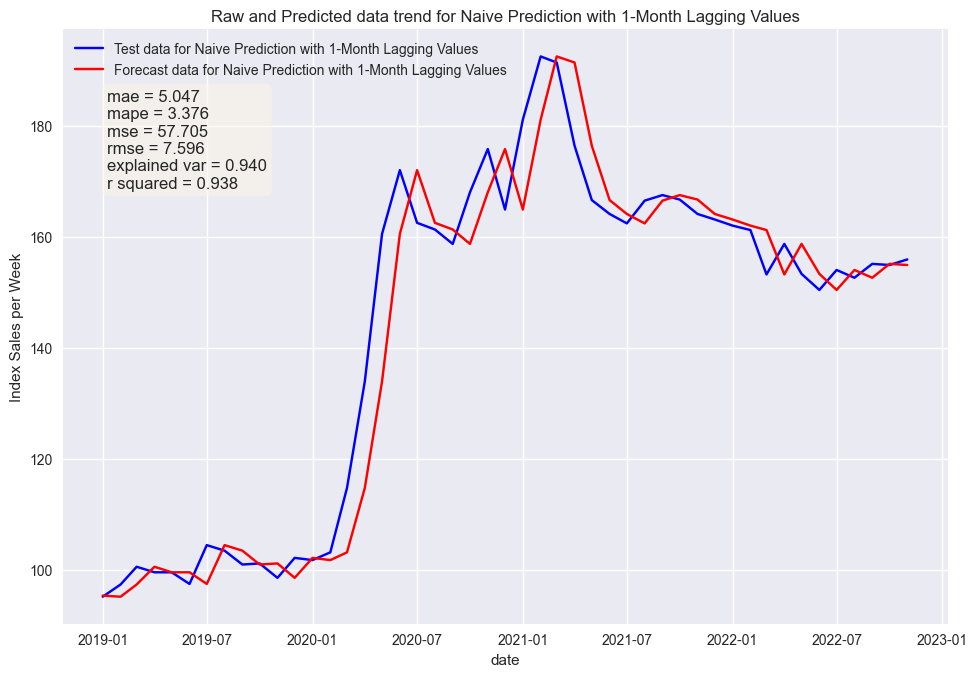

In [191]:
naive_lag_1M_score = plot_predictions(y_test, 
                                        X_test["KPC4_lag_1"], 
                                        "Naive Prediction with 1-Month Lagging Values", 
                                        "Index Sales per Week")

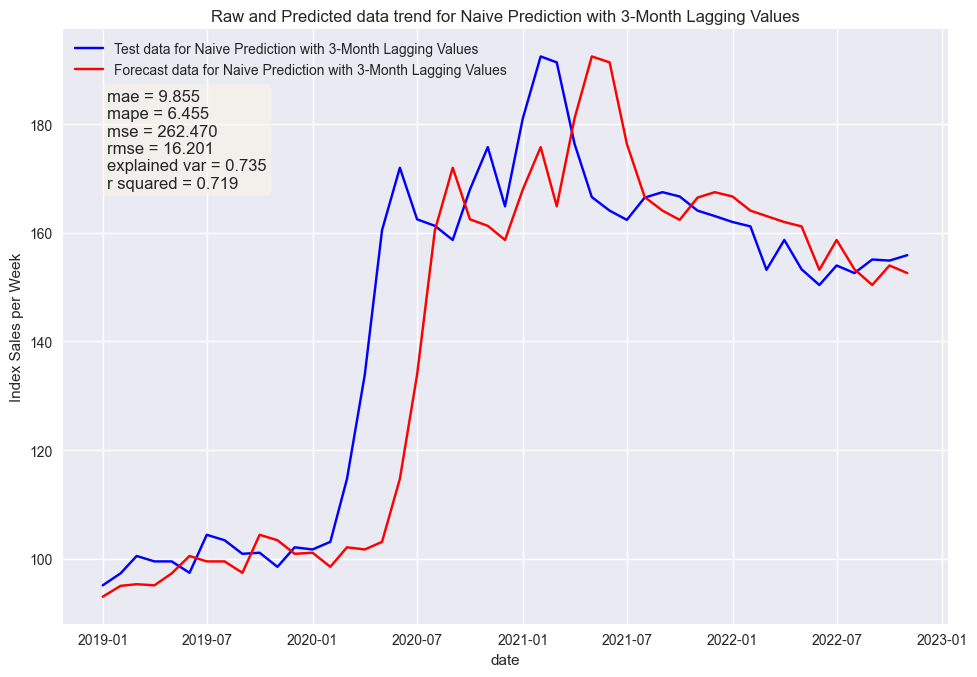

In [192]:
naive_lag_3M_score = plot_predictions(y_test, 
                                        X_test["KPC4_lag_3"], 
                                        "Naive Prediction with 3-Month Lagging Values", 
                                        "Index Sales per Week")

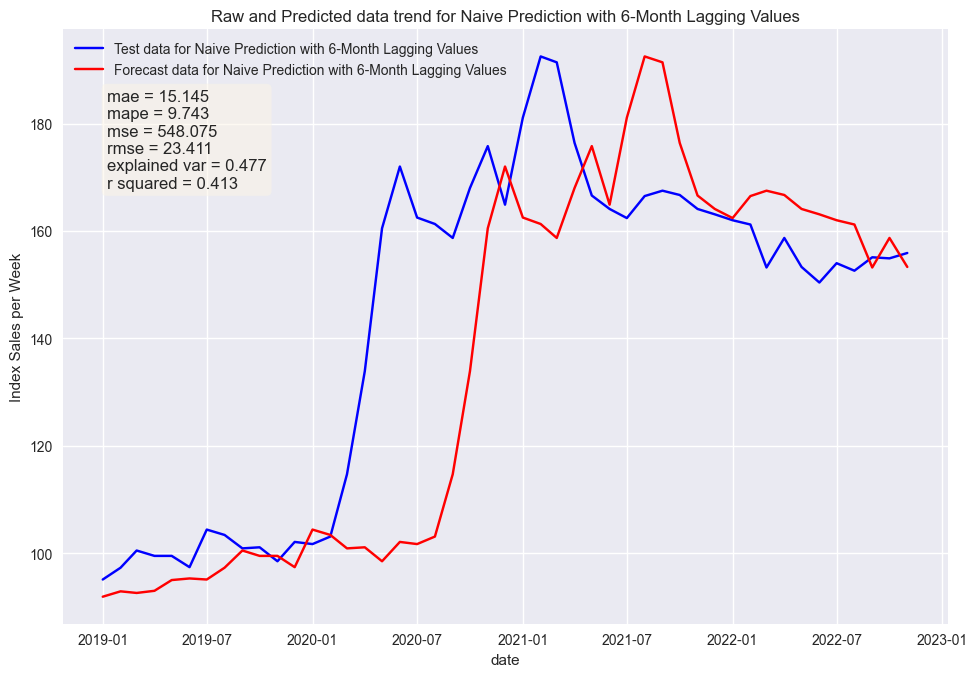

In [193]:
naive_lag_6M_score = plot_predictions(y_test, 
                                        X_test["KPC4_lag_6"], 
                                        "Naive Prediction with 6-Month Lagging Values", 
                                        "Index Sales per Week")

#### RandomForest Regressor

In [194]:
rf_model = RandomForestRegressor(
    n_estimators=50,
    max_depth=4,
    random_state=0,
    min_samples_split=4,
    min_samples_leaf=4,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, min_samples_leaf=4, min_samples_split=4,
                      n_estimators=50, n_jobs=-1, random_state=0)

In [196]:
# X_test = X_test.drop("Prediction", axis=1)
X_test['Prediction'] = rf_model.predict(X_test)

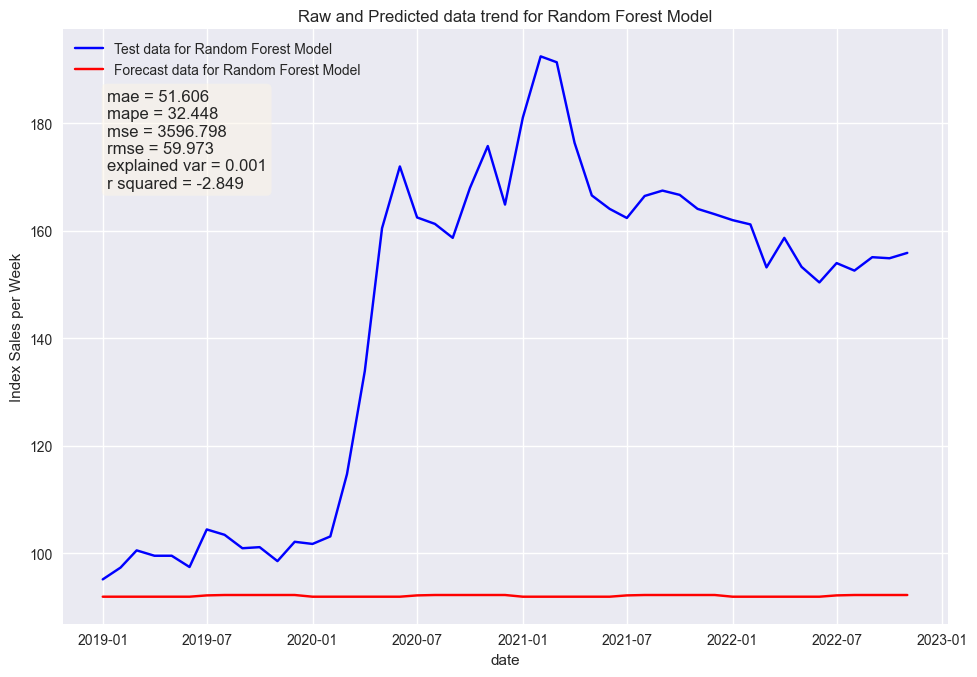

In [197]:
random_forest_score = plot_predictions(y_test, 
                                        X_test['Prediction'], 
                                        "Random Forest Model", 
                                        "Index Sales per Week")

#### Lasso Linear Regression

In [13]:
linear_model = Lasso(alpha=50, random_state=0, tol=0.01)

linear_model.fit(X_train, y_train)

Lasso(alpha=50, random_state=0, tol=0.01)

In [15]:
# X_test = X_test.drop('Prediction', axis=1)
X_test['Prediction'] = linear_model.predict(X_test)

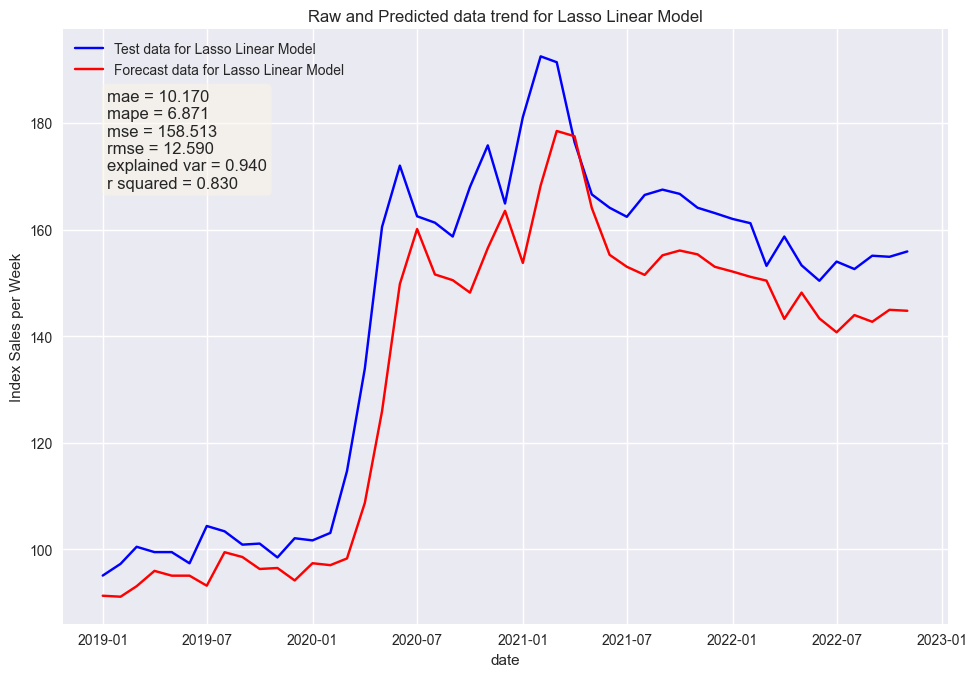

In [16]:
lasso_score = plot_predictions(y_test, X_test['Prediction'] , 
                             "Lasso Linear Model", "Index Sales per Week")

#### XGBoost

In [201]:
X_test = X_test.drop('Prediction', axis=1)

In [202]:
reg = xgb.XGBRegressor(n_estimators=80)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True)

[0]	validation_0-rmse:39.31391	validation_1-rmse:123.03549
[1]	validation_0-rmse:28.09766	validation_1-rmse:106.66812
[2]	validation_0-rmse:20.13245	validation_1-rmse:94.17349
[3]	validation_0-rmse:14.45571	validation_1-rmse:86.26108
[4]	validation_0-rmse:10.39919	validation_1-rmse:79.07463
[5]	validation_0-rmse:7.51493	validation_1-rmse:74.05099
[6]	validation_0-rmse:5.45520	validation_1-rmse:70.16847
[7]	validation_0-rmse:4.00182	validation_1-rmse:67.64249
[8]	validation_0-rmse:2.95455	validation_1-rmse:65.36874
[9]	validation_0-rmse:2.22098	validation_1-rmse:63.71515
[10]	validation_0-rmse:1.68580	validation_1-rmse:62.42729
[11]	validation_0-rmse:1.30644	validation_1-rmse:61.53114
[12]	validation_0-rmse:1.01398	validation_1-rmse:60.76611
[13]	validation_0-rmse:0.80472	validation_1-rmse:60.19446
[14]	validation_0-rmse:0.66018	validation_1-rmse:59.61353
[15]	validation_0-rmse:0.54760	validation_1-rmse:59.15023
[16]	validation_0-rmse:0.45049	validation_1-rmse:58.82030
[17]	validation_0

C:\Users\rizdi\miniconda3\envs\feature_engineering\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[48]	validation_0-rmse:0.01341	validation_1-rmse:57.39906
[49]	validation_0-rmse:0.01278	validation_1-rmse:57.39879
[50]	validation_0-rmse:0.01113	validation_1-rmse:57.39794
[51]	validation_0-rmse:0.00960	validation_1-rmse:57.39763
[52]	validation_0-rmse:0.00850	validation_1-rmse:57.39759
[53]	validation_0-rmse:0.00773	validation_1-rmse:57.39652
[54]	validation_0-rmse:0.00748	validation_1-rmse:57.39623
[55]	validation_0-rmse:0.00697	validation_1-rmse:57.39561
[56]	validation_0-rmse:0.00660	validation_1-rmse:57.39546
[57]	validation_0-rmse:0.00586	validation_1-rmse:57.39568
[58]	validation_0-rmse:0.00550	validation_1-rmse:57.39491
[59]	validation_0-rmse:0.00534	validation_1-rmse:57.39444
[60]	validation_0-rmse:0.00471	validation_1-rmse:57.39399
[61]	validation_0-rmse:0.00419	validation_1-rmse:57.39387
[62]	validation_0-rmse:0.00374	validation_1-rmse:57.39316
[63]	validation_0-rmse:0.00331	validation_1-rmse:57.39307
[64]	validation_0-rmse:0.00313	validation_1-rmse:57.39268
[65]	validatio

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=80, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

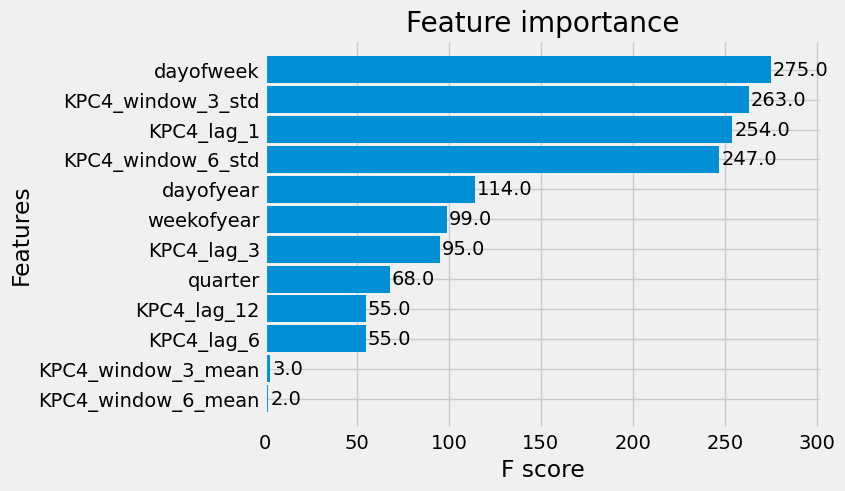

In [203]:
_ = plot_importance(reg, height=0.9)
plt.show()

In [204]:
X_test['Prediction'] = reg.predict(X_test)

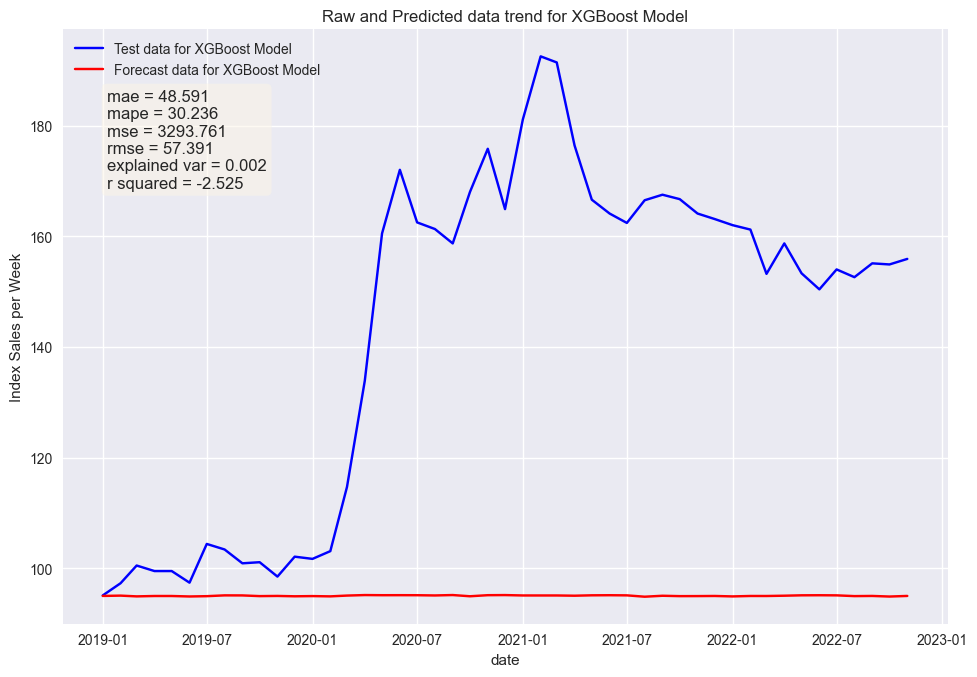

In [205]:
xgb_score = plot_predictions(y_test, X_test['Prediction'] , 
                             "XGBoost Model", "Index Sales per Week")

#### LGBM

In [206]:
from lightgbm import LGBMRegressor 

lgb = LGBMRegressor(learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31,)
lgb.fit(X_train, y_train)

LGBMRegressor()

In [207]:
X_test = X_test.drop('Prediction', axis=1)
X_test['Prediction'] = lgb.predict(X_test)

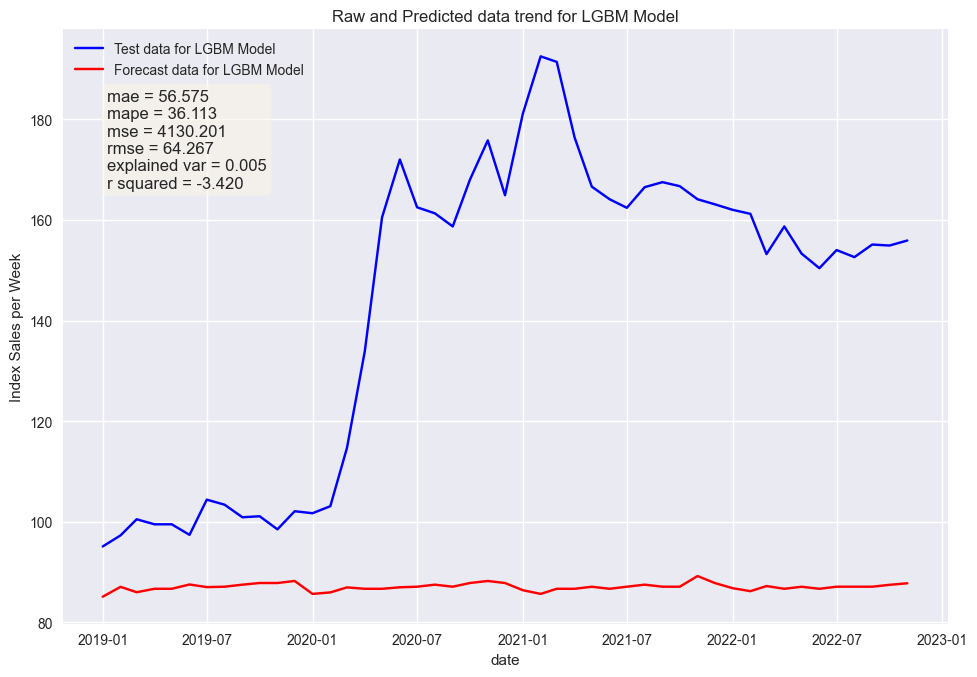

In [208]:
lgbm_score = plot_predictions(y_test, X_test['Prediction'] , 
                             "LGBM Model", "Index Sales per Week")

#### Exponential Smoothing Holt-Winters

In [18]:
train_ets, test_ets = train['Log_KPC4'], test['Log_KPC4']

In [17]:
def exp_smoothing(train, test, trend, seasonal, smooth_slope, damping_slope):
    output = {}
    
    exp_smoothing_model = ExponentialSmoothing(train,
                                               trend=trend,
                                               seasonal=seasonal,
                                               # seasonal_periods=periods,
                                               damped_trend=False
                                              )
    # see note 1 below in next cell
    exp_fit = exp_smoothing_model.fit(smoothing_level=0.7,
                                      smoothing_seasonal=0.2,
                                      smoothing_trend=smooth_slope,
                                      damping_trend=damping_slope,
                                      use_brute=False,
                                      remove_bias=False)
    forecast = exp_fit.predict(train.index[-1], test.index[-1])
    output['model'] = exp_fit
    output['forecast'] = forecast[1:]
    return output

In [19]:
prediction = exp_smoothing(
    train_ets, test_ets, 
    'add', 'mul', 
    # 12, 
    0.8, 0.3
    )

C:\Users\rizdi\miniconda3\envs\feature_engineering\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


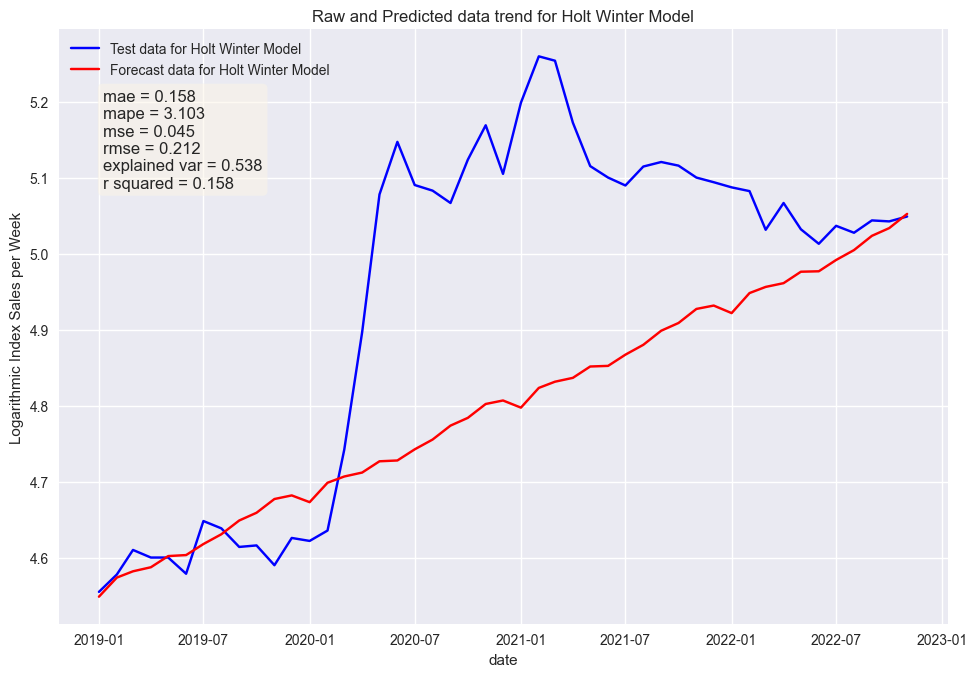

In [20]:
ets_log_score = plot_predictions(test_ets, prediction['forecast'], 
                             "Holt Winter Model", "Logarithmic Index Sales per Week")

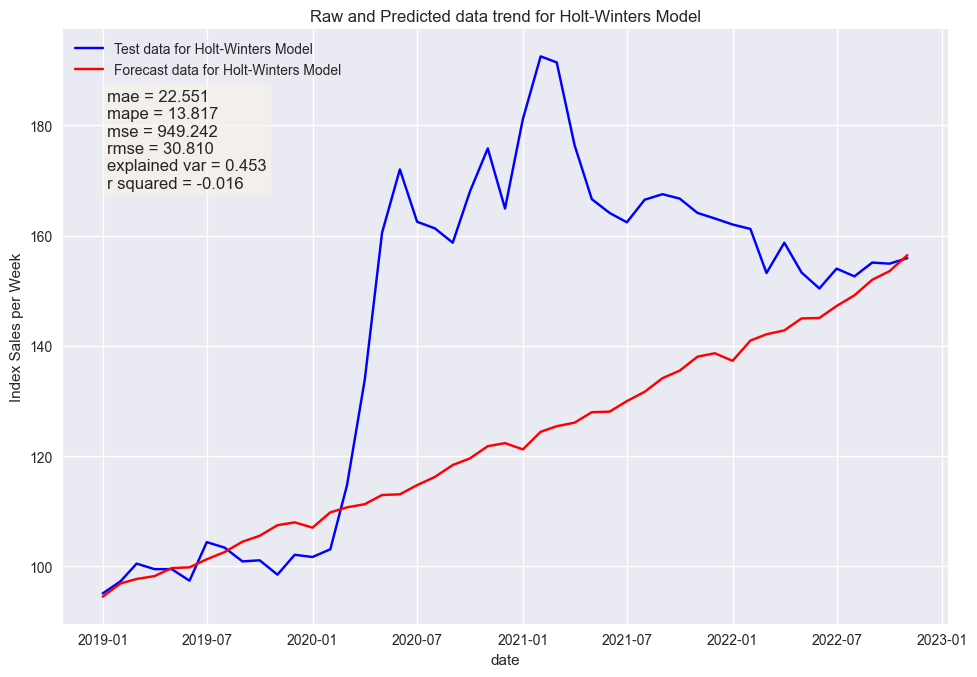

In [21]:
ets_score = plot_predictions(test['KPC4'], np.exp(prediction['forecast']), 
                             "Holt-Winters Model", "Index Sales per Week")

In [26]:
prediction['model'].forecast(55)

2019-01-01    4.548590
2019-02-01    4.573762
2019-03-01    4.582036
2019-04-01    4.587386
2019-05-01    4.602093
2019-06-01    4.603410
2019-07-01    4.617952
2019-08-01    4.630786
2019-09-01    4.648928
2019-10-01    4.659124
2019-11-01    4.677219
2019-12-01    4.681965
2020-01-01    4.673069
2020-02-01    4.698645
2020-03-01    4.706862
2020-04-01    4.712074
2020-05-01    4.726899
2020-06-01    4.727969
2020-07-01    4.742623
2020-08-01    4.755523
2020-09-01    4.773874
2020-10-01    4.784064
2020-11-01    4.802365
2020-12-01    4.806959
2021-01-01    4.797549
2021-02-01    4.823529
2021-03-01    4.831687
2021-04-01    4.836762
2021-05-01    4.851704
2021-06-01    4.852528
2021-07-01    4.867295
2021-08-01    4.880261
2021-09-01    4.898819
2021-10-01    4.909004
2021-11-01    4.927510
2021-12-01    4.931953
2022-01-01    4.922028
2022-02-01    4.948412
2022-03-01    4.956512
2022-04-01    4.961450
2022-05-01    4.976509
2022-06-01    4.977088
2022-07-01    4.991967
2022-08-01 

#### ARIMA

In [336]:
del model, model_fit, history, predictions

In [337]:
train_arima, test_arima = train['Log_KPC4'], test['Log_KPC4']

In [338]:
history = [x for x in train_arima]
predictions = []

for t in range(len(test_arima)):
    model = ARIMA(history, order=(1,1,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    
    obs = test_arima[t]
    history.append(obs)
    
    print('predicted = %f, expected = %f' % (np.exp(yhat), np.exp(obs)))

predicted = 96.673184, expected = 95.099976


C:\Users\rizdi\miniconda3\envs\feature_engineering\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 96.721438, expected = 97.299973


C:\Users\rizdi\miniconda3\envs\feature_engineering\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 98.261657, expected = 100.499977


C:\Users\rizdi\miniconda3\envs\feature_engineering\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 100.966780, expected = 99.500008


C:\Users\rizdi\miniconda3\envs\feature_engineering\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 101.163545, expected = 99.500008


C:\Users\rizdi\miniconda3\envs\feature_engineering\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 101.128657, expected = 97.400017
predicted = 99.739935, expected = 104.399986


C:\Users\rizdi\miniconda3\envs\feature_engineering\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 104.066733, expected = 103.400017


C:\Users\rizdi\miniconda3\envs\feature_engineering\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 104.920455, expected = 100.900009


C:\Users\rizdi\miniconda3\envs\feature_engineering\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 103.467265, expected = 101.100014


C:\Users\rizdi\miniconda3\envs\feature_engineering\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 103.121275, expected = 98.499985


C:\Users\rizdi\miniconda3\envs\feature_engineering\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 100.947377, expected = 102.100006


C:\Users\rizdi\miniconda3\envs\feature_engineering\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 102.697025, expected = 101.699997


C:\Users\rizdi\miniconda3\envs\feature_engineering\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 103.156626, expected = 103.099983


C:\Users\rizdi\miniconda3\envs\feature_engineering\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 104.160298, expected = 114.700005


C:\Users\rizdi\miniconda3\envs\feature_engineering\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 112.557262, expected = 133.900009
predicted = 132.095262, expected = 160.499985
predicted = 179.775321, expected = 171.999969


C:\Users\rizdi\miniconda3\envs\feature_engineering\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 190.993381, expected = 162.500031
predicted = 161.029932, expected = 161.300049
predicted = 157.255807, expected = 158.699997
predicted = 157.832400, expected = 167.999985
predicted = 170.440348, expected = 175.799973
predicted = 180.062179, expected = 164.899979
predicted = 163.912947, expected = 181.100006
predicted = 179.210694, expected = 192.500000


C:\Users\rizdi\miniconda3\envs\feature_engineering\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 196.312976, expected = 191.399994


C:\Users\rizdi\miniconda3\envs\feature_engineering\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 194.097072, expected = 176.400024


C:\Users\rizdi\miniconda3\envs\feature_engineering\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 177.599722, expected = 166.600006


C:\Users\rizdi\miniconda3\envs\feature_engineering\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 167.658720, expected = 164.100037


C:\Users\rizdi\miniconda3\envs\feature_engineering\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 165.842041, expected = 162.400040


C:\Users\rizdi\miniconda3\envs\feature_engineering\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 163.994958, expected = 166.500015


C:\Users\rizdi\miniconda3\envs\feature_engineering\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 168.777718, expected = 167.499954


C:\Users\rizdi\miniconda3\envs\feature_engineering\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 169.406818, expected = 166.699966


C:\Users\rizdi\miniconda3\envs\feature_engineering\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 168.455879, expected = 164.100037


C:\Users\rizdi\miniconda3\envs\feature_engineering\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 164.941180, expected = 163.100037


C:\Users\rizdi\miniconda3\envs\feature_engineering\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 164.417948, expected = 162.000031


C:\Users\rizdi\miniconda3\envs\feature_engineering\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 163.288276, expected = 161.199997


C:\Users\rizdi\miniconda3\envs\feature_engineering\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 162.293612, expected = 153.200027


C:\Users\rizdi\miniconda3\envs\feature_engineering\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 153.747656, expected = 158.699997


C:\Users\rizdi\miniconda3\envs\feature_engineering\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 160.438668, expected = 153.300003
predicted = 153.170619, expected = 150.400009


C:\Users\rizdi\miniconda3\envs\feature_engineering\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 151.513225, expected = 153.999985


C:\Users\rizdi\miniconda3\envs\feature_engineering\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 155.147868, expected = 152.599991


C:\Users\rizdi\miniconda3\envs\feature_engineering\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 153.650165, expected = 155.100021


C:\Users\rizdi\miniconda3\envs\feature_engineering\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 156.973093, expected = 154.900040
predicted = 156.308722, expected = 155.900009


C:\Users\rizdi\miniconda3\envs\feature_engineering\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [339]:
predictions_series = pd.Series(predictions, index = test_arima.index)

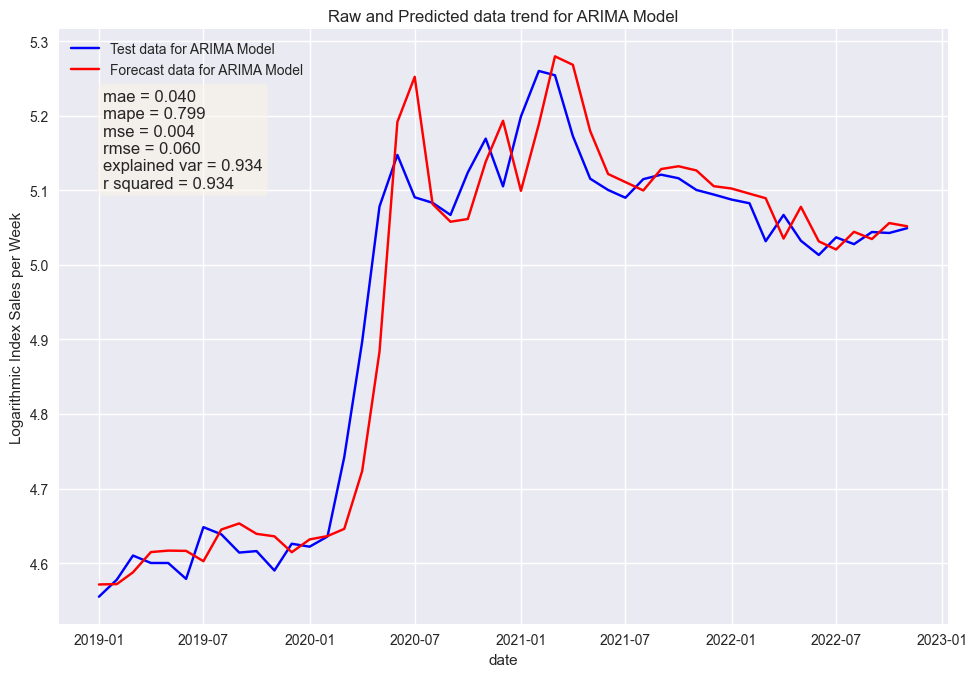

In [340]:
arima_log_score = plot_predictions(test_arima, predictions_series, 
                             "ARIMA Model", "Logarithmic Index Sales per Week")

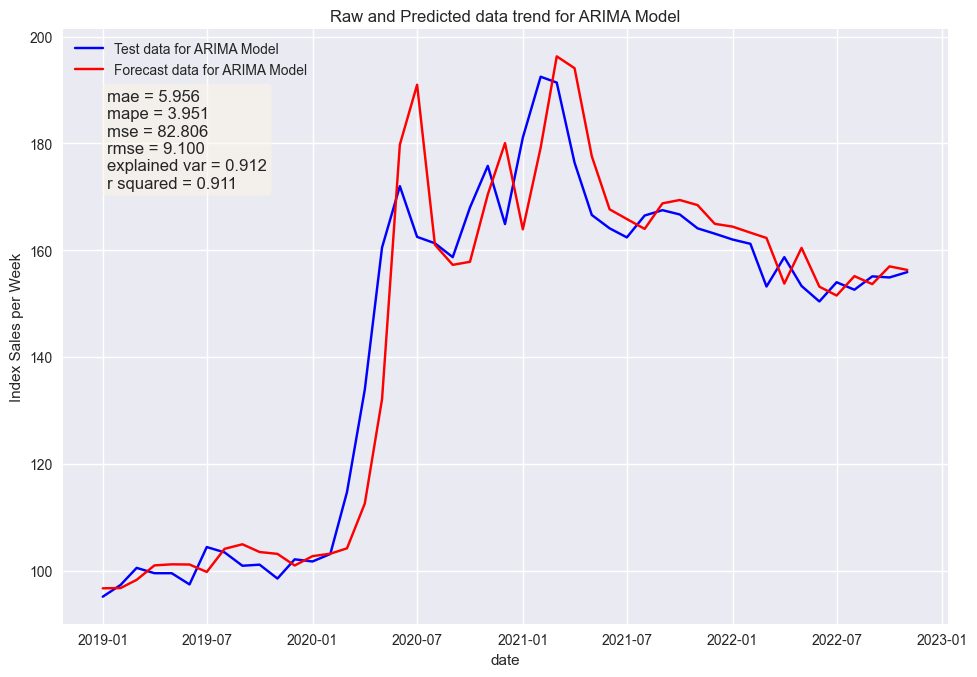

In [341]:
arima_score = plot_predictions(test['KPC4'], np.exp(predictions_series), 
                             "ARIMA Model", "Index Sales per Week")

#### Ridge Regression

In [34]:
X_train.index.inferred_freq

'MS'

In [30]:
from sklearn.linear_model import Ridge

params = {
            'alpha': 0.01, 
            'solver': 'saga',
            'tol': 0.005,
            'fit_intercept': True
             }

ridge_lr = Ridge(**params)

ridge_lr.fit(X_train, y_train)

Ridge(alpha=0.01, solver='saga', tol=0.005)

In [32]:
X_test = X_test.drop('Prediction', axis=1)
X_test['Prediction'] = ridge_lr.predict(X_test)

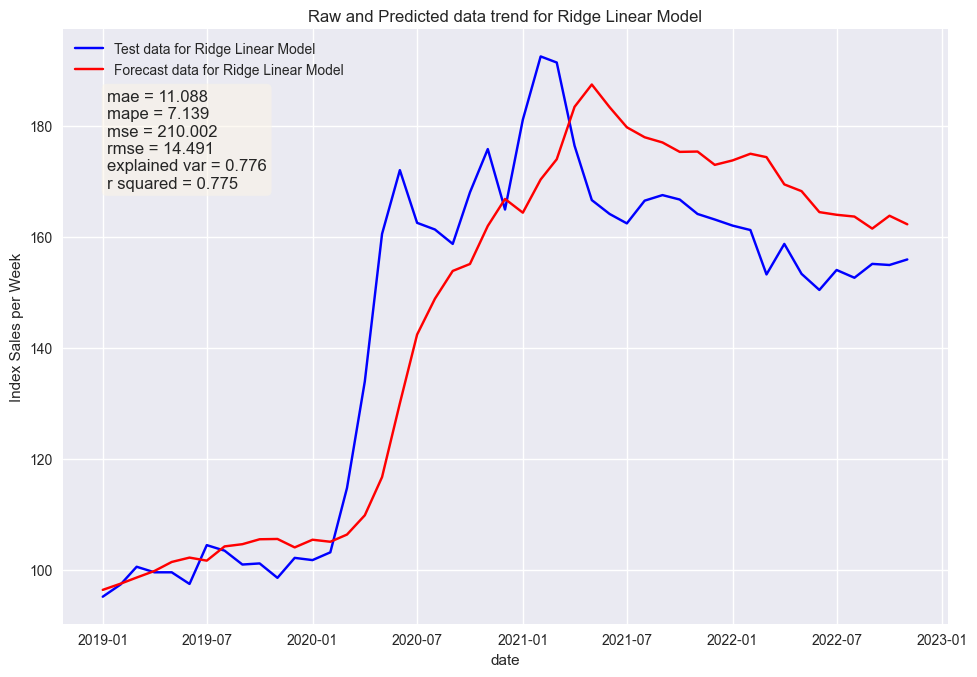

In [33]:
ridge_score = plot_predictions(y_test, X_test['Prediction'] , 
                             "Ridge Linear Model", "Index Sales per Week")

In [93]:
pd.Period("01/01/2019", freq="MS")

ValueError: Invalid frequency: <MonthBegin>

In [52]:
# Define time of first forecast, this determines our train / test split                                                    
forecast_start_time = pd.Period("2019-01-01", freq="M")

# Define number of steps to forecast.
num_of_forecast_steps = 55

# Create a list of periods that we'll forecast over.
forecast_horizon = pd.period_range(forecast_start_time, 
                                   periods=num_of_forecast_steps,
                                   freq="M")

# How much data in the past is needed to create our features
look_back_window_size = 12 # We need the latest 12 time periods
                           # in our predict dataframe to build our 
                           # window features.

In [56]:
type(forecast_start_time)

pandas._libs.tslibs.period.Period

In [86]:
data_copy = data.copy()


,KPC4,KPB8,dayofweek,quarter,dayofyear,dayofmonth,weekofyear,KPC4_lag_1,KPB8_lag_1,KPC4_lag_3,...,KPC4_lag_12,KPB8_lag_12,KPC4_window_3_mean,KPC4_window_3_std,KPB8_window_3_mean,KPB8_window_3_std,KPC4_window_6_mean,KPC4_window_6_std,KPB8_window_6_mean,KPB8_window_6_std
date,,,,,,,,,,,,,,,,,,,,,
2009-01-01,21.1,30.7,3,1,1,1,1,20.9,33.0,19.6,...,15.3,22.5,20.100000,0.700000,30.900000,2.206808,19.633333,0.791623,28.950000,2.622022
2009-02-01,21.6,29.2,6,1,32,1,5,21.1,30.7,19.8,...,16.2,22.5,20.600000,0.700000,31.600000,1.228821,20.066667,0.758068,29.733333,2.238452
2009-03-01,21.6,31.2,6,1,60,1,9,21.6,29.2,20.9,...,16.6,22.6,21.200000,0.360555,30.966667,1.913984,20.466667,0.838252,30.083333,1.879805
2009-04-01,22.3,30.5,2,2,91,1,14,21.6,31.2,21.1,...,17.4,23.6,21.433333,0.288675,30.366667,1.040833,20.766667,0.873308,30.633333,1.570563
2009-05-01,22.5,33.3,4,2,121,1,18,22.3,30.5,21.6,...,17.7,24.1,21.833333,0.404145,30.300000,1.014889,21.216667,0.847152,30.950000,1.234099


In [88]:
data_copy.sort_index().asfreq(freq='M')

,KPC4,KPB8,dayofweek,quarter,dayofyear,dayofmonth,weekofyear,KPC4_lag_1,KPB8_lag_1,KPC4_lag_3,...,KPC4_lag_12,KPB8_lag_12,KPC4_window_3_mean,KPC4_window_3_std,KPB8_window_3_mean,KPB8_window_3_std,KPC4_window_6_mean,KPC4_window_6_std,KPB8_window_6_mean,KPB8_window_6_std
date,,,,,,,,,,,,,,,,,,,,,
2009-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
# data_copy = data_copy.reset_index()
# data_copy['Dates'] = data_copy['date'].asfreq('M')
data_copy.sort_index().asfreq(freq='M').index
data_copy.head()

,date,KPC4,KPB8,dayofweek,quarter,dayofyear,dayofmonth,weekofyear,KPC4_lag_1,KPB8_lag_1,...,KPB8_lag_12,KPC4_window_3_mean,KPC4_window_3_std,KPB8_window_3_mean,KPB8_window_3_std,KPC4_window_6_mean,KPC4_window_6_std,KPB8_window_6_mean,KPB8_window_6_std,Dates
0,2009-01-01,21.1,30.7,3,1,1,1,1,20.9,33.0,...,22.5,20.100000,0.700000,30.900000,2.206808,19.633333,0.791623,28.950000,2.622022,NaT
1,2009-02-01,21.6,29.2,6,1,32,1,5,21.1,30.7,...,22.5,20.600000,0.700000,31.600000,1.228821,20.066667,0.758068,29.733333,2.238452,NaT
2,2009-03-01,21.6,31.2,6,1,60,1,9,21.6,29.2,...,22.6,21.200000,0.360555,30.966667,1.913984,20.466667,0.838252,30.083333,1.879805,NaT
3,2009-04-01,22.3,30.5,2,2,91,1,14,21.6,31.2,...,23.6,21.433333,0.288675,30.366667,1.040833,20.766667,0.873308,30.633333,1.570563,NaT
4,2009-05-01,22.5,33.3,4,2,121,1,18,22.3,30.5,...,24.1,21.833333,0.404145,30.300000,1.014889,21.216667,0.847152,30.950000,1.234099,NaT


In [81]:
data_copy = data_copy.reset_index()
data_copy['date'] = data_copy['date'].asfreq('M')
data_copy = (data_copy
 .assign(Date=lambda d: pd.to_datetime(d['date']))
 .set_index('Date')
 .drop(columns='date')
 )

In [82]:
data_copy.head()

,KPC4,KPB8,dayofweek,quarter,dayofyear,dayofmonth,weekofyear,KPC4_lag_1,KPB8_lag_1,KPC4_lag_3,...,KPC4_lag_12,KPB8_lag_12,KPC4_window_3_mean,KPC4_window_3_std,KPB8_window_3_mean,KPB8_window_3_std,KPC4_window_6_mean,KPC4_window_6_std,KPB8_window_6_mean,KPB8_window_6_std
Date,,,,,,,,,,,,,,,,,,,,,
NaT,21.1,30.7,3,1,1,1,1,20.9,33.0,19.6,...,15.3,22.5,20.100000,0.700000,30.900000,2.206808,19.633333,0.791623,28.950000,2.622022
NaT,21.6,29.2,6,1,32,1,5,21.1,30.7,19.8,...,16.2,22.5,20.600000,0.700000,31.600000,1.228821,20.066667,0.758068,29.733333,2.238452
NaT,21.6,31.2,6,1,60,1,9,21.6,29.2,20.9,...,16.6,22.6,21.200000,0.360555,30.966667,1.913984,20.466667,0.838252,30.083333,1.879805
NaT,22.3,30.5,2,2,91,1,14,21.6,31.2,21.1,...,17.4,23.6,21.433333,0.288675,30.366667,1.040833,20.766667,0.873308,30.633333,1.570563
NaT,22.5,33.3,4,2,121,1,18,22.3,30.5,21.6,...,17.7,24.1,21.833333,0.404145,30.300000,1.014889,21.216667,0.847152,30.950000,1.234099


In [79]:
data_copy.index.inferred_freq

'MS'

In [66]:
ridge_train = data.loc[data.index < split_date].copy()
ridge_test = data.loc[data.index >= split_date].copy()

In [67]:
# the target variable
y_train = ridge_train["KPC4"].copy()
y_test = ridge_test["KPC4"].copy()

# remove raw time series from predictors set
X_train = ridge_train.drop(['KPC4','KPB8','KPB8_lag_1', 'KPB8_lag_3',
                    'KPB8_lag_6', 'KPB8_lag_12',
                    'KPB8_window_3_mean', 'KPB8_window_3_std',
                            'KPB8_window_6_mean', 'KPB8_window_6_std'], axis=1)
X_test = ridge_test.drop(['KPC4','KPB8','KPB8_lag_1', 'KPB8_lag_3',
                    'KPB8_lag_6', 'KPB8_lag_12',
                    'KPB8_window_3_mean', 'KPB8_window_3_std',
                    'KPB8_window_6_mean', 'KPB8_window_6_std'], axis=1)

In [ ]:
params = {
            'alpha': 0.01, 
            'solver': 'saga',
            'tol': 0.005,
            'fit_intercept': True
             }

ridge_lr = Ridge(**params)

ridge_lr.fit(X_train, y_train)

In [68]:
for forecast_time in forecast_horizon: 
    print(forecast_time)

2019-01
2019-02
2019-03
2019-04
2019-05
2019-06
2019-07
2019-08
2019-09
2019-10
2019-11
2019-12
2020-01
2020-02
2020-03
2020-04
2020-05
2020-06
2020-07
2020-08
2020-09
2020-10
2020-11
2020-12
2021-01
2021-02
2021-03
2021-04
2021-05
2021-06
2021-07
2021-08
2021-09
2021-10
2021-11
2021-12
2022-01
2022-02
2022-03
2022-04
2022-05
2022-06
2022-07
2022-08
2022-09
2022-10
2022-11
2022-12
2023-01
2023-02
2023-03
2023-04
2023-05
2023-06
2023-07


In [69]:
X_test.head()

,dayofweek,quarter,dayofyear,dayofmonth,weekofyear,KPC4_lag_1,KPC4_lag_3,KPC4_lag_6,KPC4_lag_12,KPC4_window_3_mean,KPC4_window_3_std,KPC4_window_6_mean,KPC4_window_6_std,Log_KPC4,Log_KPB8
date,,,,,,,,,,,,,,,
2019-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### MVP Evaluation and Selection

In [ ]:
### Winner:
Lasso, Ridge,ARIMA

### 2) KPB8 (Retail Food)

In [62]:
# the target variable
y_train = train["KPB8"].copy()
y_test = test["KPB8"].copy()

# remove raw time series from predictors set
X_train = train.drop(['KPC4','KPB8','KPC4_lag_1', 'KPC4_lag_3',
                    'KPC4_lag_6', 'KPC4_lag_12',
                    'KPC4_window_3_mean', 'KPC4_window_3_std',
                    'KPC4_window_6_mean', 'KPC4_window_6_std'], axis=1)
X_test = test.drop(['KPC4','KPB8','KPC4_lag_1', 'KPC4_lag_3',
                    'KPC4_lag_6', 'KPC4_lag_12',
                    'KPC4_window_3_mean', 'KPC4_window_3_std',
                    'KPC4_window_6_mean', 'KPC4_window_6_std'], axis=1)

In [63]:
X_train.head()

,dayofweek,quarter,dayofyear,dayofmonth,weekofyear,KPB8_lag_1,KPB8_lag_3,KPB8_lag_6,KPB8_lag_12,KPB8_window_3_mean,KPB8_window_3_std,KPB8_window_6_mean,KPB8_window_6_std
date,,,,,,,,,,,,,
2009-01-01,3,1,1,1,1,33.000000,28.600000,26.0,22.5,30.900000,2.206808,28.950001,2.622022
2009-02-01,6,1,32,1,5,30.700001,31.100000,27.1,22.5,31.600000,1.228821,29.733334,2.238452
2009-03-01,6,1,60,1,9,29.200001,33.000000,27.9,22.6,30.966667,1.913984,30.083334,1.879805
2009-04-01,2,2,91,1,14,31.200001,30.700001,28.6,23.6,30.366667,1.040833,30.633333,1.570562
2009-05-01,4,2,121,1,18,30.500000,29.200001,31.1,24.1,30.299999,1.014889,30.950001,1.234099


#### Naive Forecast

In [64]:
# Performance of naive forecast

print("train rmse on lagging value by 1 month: ", mean_squared_error(
    y_train, X_train["KPB8_lag_1"], squared=False,))

print("test rmse on lagging value by 1 month: ",  mean_squared_error(
    y_test, X_test["KPB8_lag_1"], squared=False,))

print("train rmse on lagging value by 3 months: ", mean_squared_error(
    y_train, X_train["KPB8_lag_3"], squared=False,))

print("test rmse on lagging value by 3 months: ",  mean_squared_error(
    y_test, X_test["KPB8_lag_3"], squared=False,))

train rmse on lagging value by 1 month:  2.4142907
test rmse on lagging value by 1 month:  15.241087
train rmse on lagging value by 3 months:  3.4366028
test rmse on lagging value by 3 months:  31.898176


In [65]:
# Performance of naive forecast

print("train rmse on lagging value by 6 months: ", mean_squared_error(
    y_train, X_train["KPB8_lag_6"], squared=False,))

print("test rmse on lagging value by 6 months: ",  mean_squared_error(
    y_test, X_test["KPB8_lag_6"], squared=False,))

print("train rmse on lagging value by 12 months: ", mean_squared_error(
    y_train, X_train["KPB8_lag_12"], squared=False,))

print("test rmse on lagging value by 12 months: ",  mean_squared_error(
    y_test, X_test["KPB8_lag_12"], squared=False,))

train rmse on lagging value by 6 months:  4.767817
test rmse on lagging value by 6 months:  43.697327
train rmse on lagging value by 12 months:  8.20276
test rmse on lagging value by 12 months:  63.527542


#### Random Forest

In [66]:
rf_model = RandomForestRegressor(
    n_estimators=50,
    max_depth=4,
    random_state=0,
    min_samples_split=4,
    min_samples_leaf=4,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, min_samples_leaf=4, min_samples_split=4,
                      n_estimators=50, n_jobs=-1, random_state=0)

In [67]:
print("train rmse: ", mean_squared_error(
    y_train, rf_model.predict(X_train), squared=False,))

print("test rmse: ",  mean_squared_error(
    y_test, rf_model.predict(X_test), squared=False,))

train rmse:  1.567890972434648
test rmse:  89.00211961203813


#### Lasso Regression

In [69]:
linear_model = Lasso(alpha=70, random_state=0, tol=0.001)

linear_model.fit(X_train, y_train)

Lasso(alpha=70, random_state=0, tol=0.001)

In [70]:
print("train rmse: ", mean_squared_error(
    y_train, linear_model.predict(X_train), squared=False,))

print("test rmse: ",  mean_squared_error(
    y_test, linear_model.predict(X_test), squared=False,))

train rmse:  3.8238773
test rmse:  24.033243


Text(0, 0.5, 'Importance')

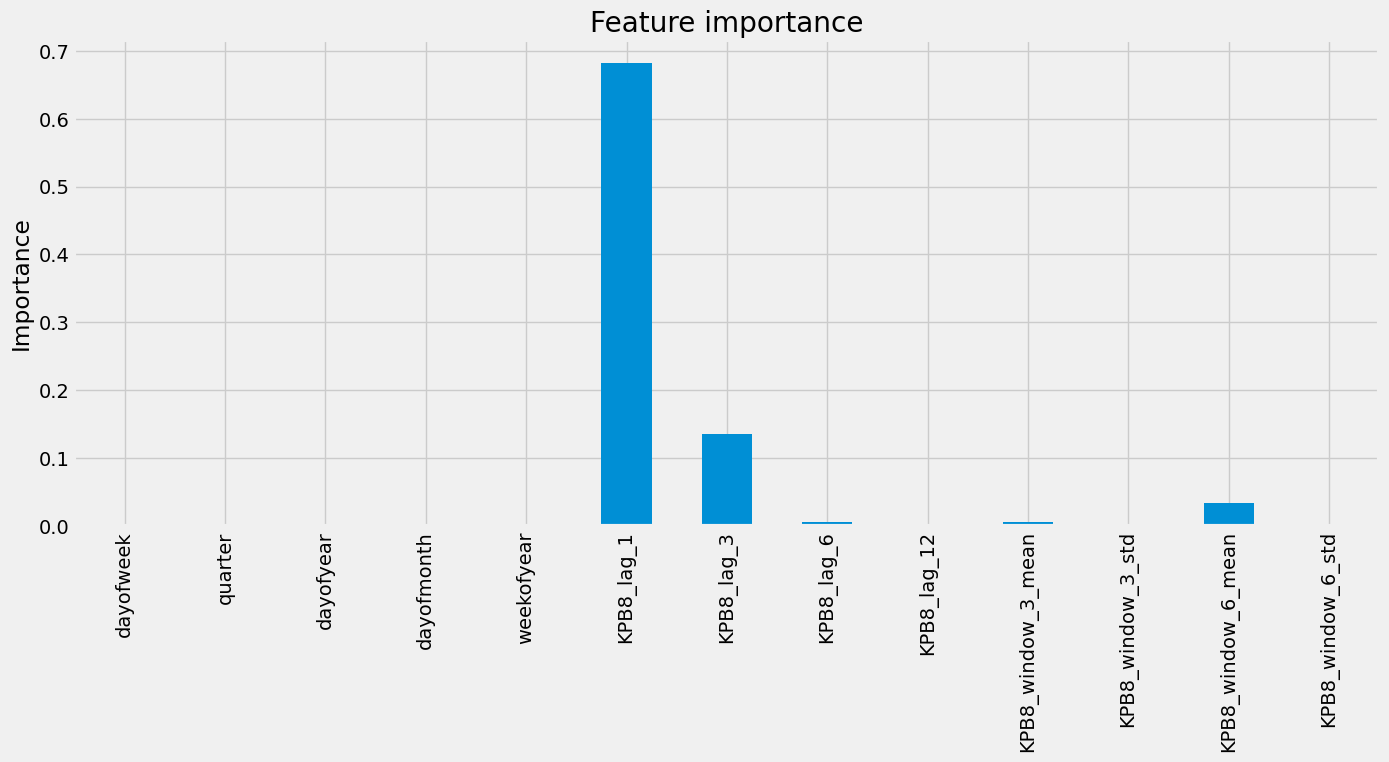

In [71]:
# Create series with feature importance.
tmp = pd.Series(np.abs(linear_model.coef_))

# Let's add the variable names.
tmp.index = X_train.columns

# Let's make a bar plot.
tmp.plot.bar(figsize=(15, 6))
plt.title("Feature importance")
plt.ylabel("Importance")

In [72]:
X_test['Prediction'] = linear_model.predict(X_test)
kpp8_all = pd.concat([X_test, X_train], sort=False)
kpp8_all['KPB8'] = pd.concat([y_test, y_train], sort=False)

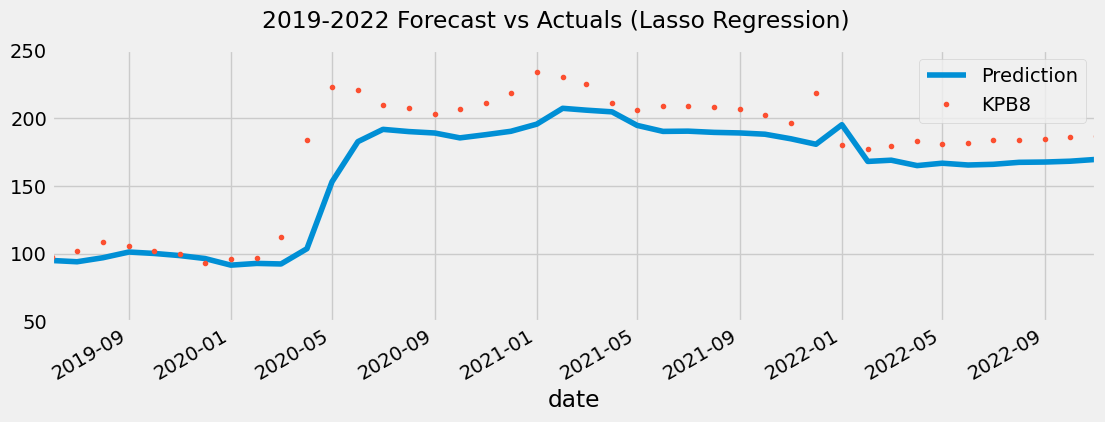

In [75]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(4)
f.set_figwidth(12)
_ = kpp8_all[['Prediction','KPB8']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='2019-06-01', upper='2022-11-01')
ax.set_ylim(50, 250)
plt.suptitle('2019-2022 Forecast vs Actuals (Lasso Regression)')
plt.show()

#### XGBoost

In [77]:
X_test = X_test.drop("Prediction", axis=1)

In [78]:
reg = xgb.XGBRegressor(n_estimators=80)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True)

[0]	validation_0-rmse:48.21216	validation_1-rmse:157.79454
[1]	validation_0-rmse:34.28393	validation_1-rmse:138.84665
[2]	validation_0-rmse:24.51560	validation_1-rmse:125.95352
[3]	validation_0-rmse:17.50729	validation_1-rmse:116.12577
[4]	validation_0-rmse:12.54352	validation_1-rmse:108.90339
[5]	validation_0-rmse:9.00516	validation_1-rmse:103.45111
[6]	validation_0-rmse:6.52777	validation_1-rmse:99.60330
[7]	validation_0-rmse:4.77817	validation_1-rmse:96.78811
[8]	validation_0-rmse:3.53413	validation_1-rmse:94.69589
[9]	validation_0-rmse:2.64912	validation_1-rmse:93.28437
[10]	validation_0-rmse:2.01083	validation_1-rmse:92.85764
[11]	validation_0-rmse:1.55254	validation_1-rmse:92.52697
[12]	validation_0-rmse:1.21887	validation_1-rmse:92.11872
[13]	validation_0-rmse:0.97024	validation_1-rmse:91.79493
[14]	validation_0-rmse:0.78897	validation_1-rmse:91.63787
[15]	validation_0-rmse:0.64457	validation_1-rmse:91.42870
[16]	validation_0-rmse:0.53601	validation_1-rmse:91.29561
[17]	validati

C:\Users\rizdi\miniconda3\envs\feature_engineering\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[44]	validation_0-rmse:0.02452	validation_1-rmse:90.90414
[45]	validation_0-rmse:0.02241	validation_1-rmse:90.90370
[46]	validation_0-rmse:0.02059	validation_1-rmse:90.90352
[47]	validation_0-rmse:0.01971	validation_1-rmse:90.90369
[48]	validation_0-rmse:0.01776	validation_1-rmse:90.90330
[49]	validation_0-rmse:0.01570	validation_1-rmse:90.90308
[50]	validation_0-rmse:0.01442	validation_1-rmse:90.90302
[51]	validation_0-rmse:0.01230	validation_1-rmse:90.90321
[52]	validation_0-rmse:0.01070	validation_1-rmse:90.90318
[53]	validation_0-rmse:0.00974	validation_1-rmse:90.90224
[54]	validation_0-rmse:0.00855	validation_1-rmse:90.90183
[55]	validation_0-rmse:0.00757	validation_1-rmse:90.90194
[56]	validation_0-rmse:0.00678	validation_1-rmse:90.90164
[57]	validation_0-rmse:0.00625	validation_1-rmse:90.90154
[58]	validation_0-rmse:0.00551	validation_1-rmse:90.90157
[59]	validation_0-rmse:0.00467	validation_1-rmse:90.90154
[60]	validation_0-rmse:0.00429	validation_1-rmse:90.90156
[61]	validatio

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=80, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [79]:
X_test['Prediction'] = reg.predict(X_test)
kpb8_all = pd.concat([X_test, X_train], sort=False)
kpb8_all['KPB8'] = pd.concat([y_test, y_train], sort=False)

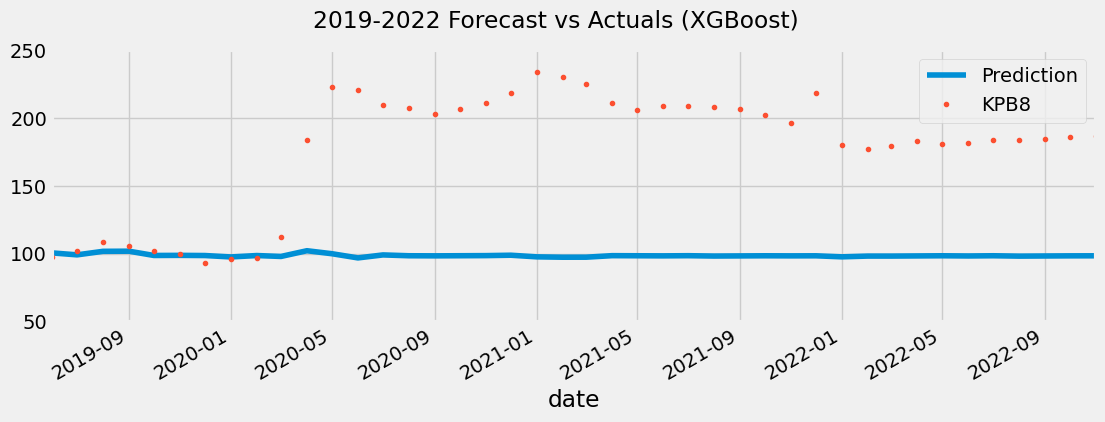

In [81]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(4)
f.set_figwidth(12)
_ = kpb8_all[['Prediction','KPB8']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='2019-06-01', upper='2022-11-01')
ax.set_ylim(50, 250)
plt.suptitle('2019-2022 Forecast vs Actuals (XGBoost)')
plt.show()

#### LGBM

In [82]:
from lightgbm import LGBMRegressor 

lgb = LGBMRegressor(learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31,)
lgb.fit(X_train, y_train)

LGBMRegressor()

In [86]:
print("train rmse: ", mean_squared_error(
    y_train, lgb.predict(X_train), squared=False,))

X_test = X_test.drop("Prediction", axis=1)
print("test rmse: ",  mean_squared_error(
    y_test, lgb.predict(X_test), squared=False,))

train rmse:  1.5855569024796285
test rmse:  89.39374780824748


In [87]:
X_test['Prediction'] = lgb.predict(X_test)
kpp8_all = pd.concat([X_test, X_train], sort=False)
kpp8_all['KPB8'] = pd.concat([y_test, y_train], sort=False)

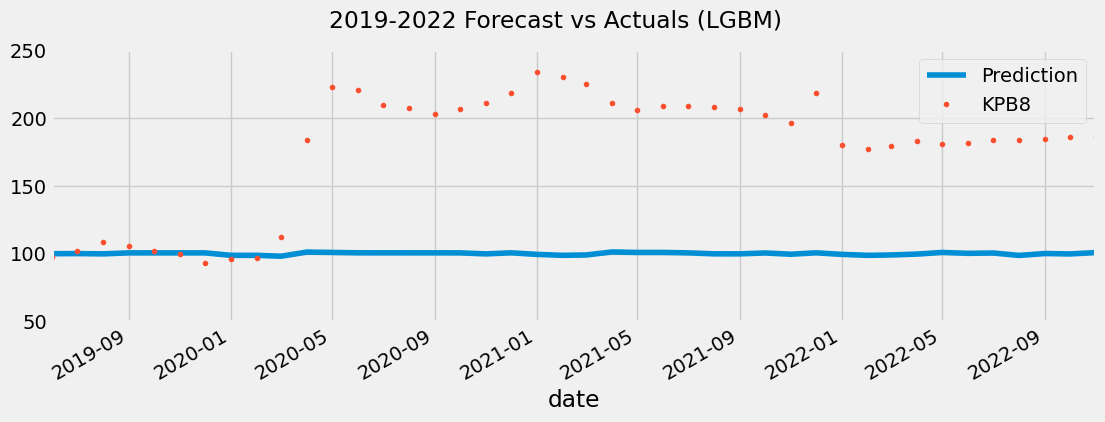

In [89]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(4)
f.set_figwidth(12)
_ = kpp8_all[['Prediction','KPB8']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='2019-06-01', upper='2022-11-01')
ax.set_ylim(50, 250)
plt.suptitle('2019-2022 Forecast vs Actuals (LGBM)')
plt.show()